In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os

'''Data Viz'''
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

'''Data Prep'''
from sklearn import preprocessing as pp 
from scipy.stats import pearsonr 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss 
from sklearn.metrics import precision_recall_curve, average_precision_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report 

'''Algos'''
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb


C:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Acquire Data from :aws3 cp s3://handson-unsupervised-learning/datasets/ datasets --recursive --no-sign-request
# https://handson-unsupervised-learning.s3.us-east-2.amazonaws.com/datasets/credit_card_data/credit_card.csv
# This data is not raw, but the output from PCA
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'credit_card_data', 'credit_card.csv'])
data = pd.read_csv(current_path + file)

In [3]:
print(data.describe)
data.columns

<bound method NDFrame.describe of             Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [4]:
print("Number of fraudulent transactions:", data['Class'].sum())

Number of fraudulent transactions: 492


In [5]:
nanCounter = np.isnan(data).sum()
nanCounter

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [6]:
distinctCounter = data.apply(lambda x: len(x.unique()))
distinctCounter

Time      124592
V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount     32767
Class          2
dtype: int64

In [20]:
dataX = data.copy().drop(['Class'],axis=1) #Create two seperate feature matrix. 
dataY = data['Class'].copy()

In [21]:
dataX.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000


In [45]:
dataXnoT = dataX.drop('Time', axis=1) #Produce a correlation matrix
correlationMatrix = pd.DataFrame(data=[],index=dataXnoT.columns,columns=dataXnoT.columns)
for i in dataXnoT.columns:
    for j in dataXnoT.columns:
        correlationMatrix.loc[i,j] = np.round(pearsonr(dataXnoT.loc[:,i],dataXnoT.loc[:,j])[0],2)


In [32]:
correlation_file = os.path.sep.join(['', 'datasets', 'credit_card_data', 'correlationMatrix.csv'])
correlationMatrix.to_csv(current_path+correlation_file)

In [47]:
dataXcorr = np.round(dataX.drop(['Time'],axis=1).corr(),4) #much simpler way to create a correlation matrix
dataXcorr

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
V1,1.0000,0.0000,-0.0000,-0.0000,0.0000,-0.000,-0.0000,-0.0000,-0.0000,0.0000,...,0.0000,-0.000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.2277
V2,0.0000,1.0000,0.0000,-0.0000,0.0000,0.000,0.0000,-0.0000,0.0000,-0.0000,...,0.0000,-0.000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.5314
V3,-0.0000,0.0000,1.0000,0.0000,-0.0000,0.000,0.0000,-0.0000,0.0000,0.0000,...,-0.0000,0.000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.2109
V4,-0.0000,-0.0000,0.0000,1.0000,-0.0000,-0.000,-0.0000,0.0000,0.0000,0.0000,...,-0.0000,-0.000,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0987
V5,0.0000,0.0000,-0.0000,-0.0000,1.0000,0.000,0.0000,0.0000,0.0000,-0.0000,...,-0.0000,-0.000,0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,-0.3864
V6,-0.0000,0.0000,0.0000,-0.0000,0.0000,1.000,0.0000,-0.0000,0.0000,0.0000,...,-0.0000,0.000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.2160
V7,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.000,1.0000,0.0000,0.0000,-0.0000,...,0.0000,-0.000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.3973
V8,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.000,0.0000,1.0000,0.0000,-0.0000,...,0.0000,0.000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.1031
V9,-0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,1.0000,-0.0000,...,-0.0000,0.000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0442
V10,0.0000,-0.0000,0.0000,0.0000,-0.0000,0.000,-0.0000,-0.0000,-0.0000,1.0000,...,-0.0000,0.000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.1015


<AxesSubplot:>

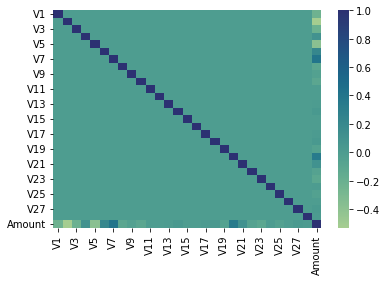

In [52]:
sns.heatmap(dataXcorr, cmap='crest') #Heatmat demonstrates PCs for the dataset are not correlated. We will not benefit from removing any features.

Text(0, 0.5, 'Frequency Percentage')

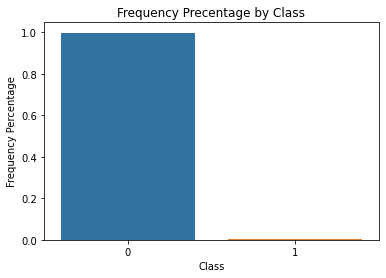

In [53]:
# Number of fraud cases to total cases
count_classes = pd.value_counts(data['Class'], sort=True).sort_index()
ax = sns.barplot(x=count_classes.index, y=[tuple(count_classes/len(data))[0],tuple(count_classes/len(data))[1]])
ax.set_title('Frequency Precentage by Class')
ax.set_xlabel('Class')
ax.set_ylabel('Frequency Percentage')

In [60]:
#split data into training and testing arrays
#Train_test_split keeps the precentage of classifications identical in the train and test arrays based on the stratify parameter
x_train, x_test, y_train, y_test = train_test_split(dataX,dataY,test_size=.33,random_state=2018,stratify=dataY) 
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

190820
93987
190820
93987


In [61]:
print(y_train.sum()/len(y_train)) 
print(y_test.sum()/len(y_test))

0.0017293784718582959
0.0017236426314277506


In [82]:
#K-fold validation sets. Training/Tests sets created through the training data to determine perfomance on different sets of information. Allows us to evaluate training and validation scores of each subset
k_fold = StratifiedKFold(n_splits=5,shuffle=True, random_state=2018)


In [83]:
#Machine Learning Model Part 1 : Logistic Regression
#Set Hyperparameters
penalty = 'l2' #l2 is less sensitive to outliers than l1, will assign non-zero weights to all featuress. L1 assigns high weights to important features and near-zero to the rest.
C = 1.0 #regularization strength to help address overfitting. The stronger the C, the greater the penalty the Ml algo applies to completity. Regularization nudges ML algo to perfer simpler models, all elese equal. Must be a positive number, smaller values are stronger regularization.
class_weight = 'balanced' #signals to the algo that weight of positive/fraud cases merit more weight 
random_state = 2018
solver = 'liblinear'


logReg = LogisticRegression(penalty=penalty, C=C, class_weight=class_weight, random_state=random_state, solver=solver, n_jobs=n_jobs)


In [100]:
#Training the linear model
trainingScores = [] #Loss function
cvScores = [] #cross validation, comparison to the 5th training slice not involved in ML training
predictionsBasedOnKFolds = pd.DataFrame(data=[], index=y_train.index,columns=[0,1])

model = logReg

for train_index, cv_index in k_fold.split(np.zeros(len(x_train)),y_train.ravel()):
    X_train_fold, X_cv_fold = x_train.iloc[train_index,:], x_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

    model.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold, model.predict_proba(X_train_fold)[:,1])
    trainingScores.append(loglossTraining)

    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = model.predict_proba(X_cv_fold)
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    cvScores.append(loglossCV)

    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)

loglossLogisticRegression = log_loss(y_train, predictionsBasedOnKFolds.loc[:,1])
print('Logistic Regression Log Loss: ', loglossLogisticRegression)

Training Log Loss:  0.10943417046943403
CV Log Loss:  0.10858635705107196
Training Log Loss:  0.10470917279856422
CV Log Loss:  0.1041652578125024
Training Log Loss:  0.11556802448675875
CV Log Loss:  0.1179847497240273
Training Log Loss:  0.11575361973723554
CV Log Loss:  0.1183380753181711
Training Log Loss:  0.09696493285127632
CV Log Loss:  0.09689053046267453
Logistic Regression Log Loss:  0.10919299407368946


Text(0.5, 1.0, 'Precision Recall Curve: Average Precision = 0.74')

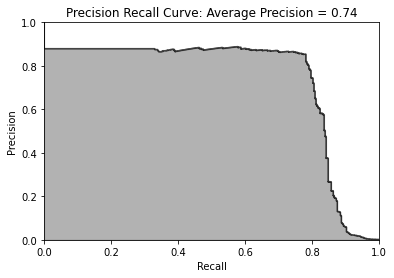

In [108]:
#Precision recall curve to calculate average precision. Allows you to determine the recall (% of total fraudulent transactions), and precision (% of true positive fraudulent transactions) 
preds = pd.concat([y_train, predictionsBasedOnKFolds.loc[:,1]],axis=1)
preds.columns = ['trueLabel', 'prediction']
predictionsBasedOnKFoldsLogistricRegression = preds.copy()

precision, recall, thresholds = precision_recall_curve(preds['trueLabel'], preds['prediction'])

average_precision = average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='k', alpha=.7,where='post')
plt.fill_between(recall,precision,step='post',alpha=.3,color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0,1])
plt.xlim([0,1])

plt.title(f'Precision Recall Curve: Average Precision = {average_precision :.2f}')

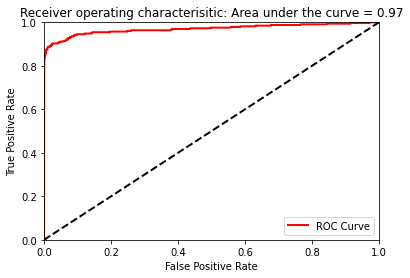

In [109]:
#auROC curve: Areas un the Receiver operating characteristic. Plost the true positive rate (sensitivity) on Y and false positive rate (1-specificity) on X. The larger the auROC, the better the model
#The area under the curve demonstrates how much fraud you can catch while keeping false positives as low as possible
fpr, tpr, thresholds = roc_curve(preds['trueLabel'], preds['prediction'])

areaUnderROC = auc(fpr,tpr)

plt.figure()
plt.plot(fpr,tpr, color='r', lw=2,label='ROC Curve')
plt.plot([0,1],[0,1],color='k', lw=2, linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title(f'Receiver operating characterisitic: Area under the curve = {areaUnderROC :0.2f}')
plt.legend(loc='lower right')
plt.show()

In [61]:
#feature scaling - we do not want time on the comparison scaling
featuresToscale = dataX.drop(['Time'],axis=1).columns
featuresToscale

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [66]:
pd.set_option('mode.chained_assignment', None) #supress pandas warnings
sX = pp.StandardScaler(copy=True)
x_train.loc[:,featuresToscale] = sX.fit_transform(x_train.loc[:,featuresToscale]) # Looks to scale the data to have a mean of 0 and stddev of 1
scalingFactors = pd.DataFrame(data=[sX.mean_, sX.scale_],index=['Mean','StdDev'],columns=featuresToscale)

x_test.loc[:,featuresToscale]= sX.fit_transform(x_test.loc[:,featuresToscale] )

scalingFactors #confirms if the mean is 0 and stddev is 1


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Mean,9.951396e-18,-3.984282e-18,-8.471254e-19,1.280928e-17,-5.604060e-18,4.244936e-18,2.308649e-18,4.319409e-18,-6.534968e-18,-2.606540e-18,...,-5.101371e-18,-2.829957e-18,2.150395e-17,4.505590e-18,-1.306063e-17,1.474557e-17,-2.457595e-18,1.489451e-18,2.308649e-18,7.037657e-18
StdDev,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [110]:
## RANDOM FOREST MODEL ##
#Set the hyperparameters
n_estimators = 10 #Number of trees to build, average the results across 10 trees 
max_features = 'auto'
max_depth = None #Tree will grow as deep as possible 
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0.0
max_leaf_nodes = None
bootstrap = True
oob_score = False
n_jobs = -1
random_state = 2018
class_weight = 'balanced'

RFC = RandomForestClassifier(n_estimators=n_estimators, 
        max_features=max_features, max_depth=max_depth,
        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
        min_weight_fraction_leaf=min_weight_fraction_leaf, 
        max_leaf_nodes=max_leaf_nodes, bootstrap=bootstrap, 
        oob_score=oob_score, n_jobs=n_jobs, random_state=random_state, 
        class_weight=class_weight)

In [111]:
#Random forest training 
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])

model = RFC

for train_index, cv_index in k_fold.split(np.zeros(len(x_train)), y_train.ravel()):
    X_train_fold, X_cv_fold = x_train.iloc[train_index,:], x_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index],y_train.iloc[cv_index]
    
    model.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold, model.predict_proba(X_train_fold)[:,1])
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = model.predict_proba(X_cv_fold)  
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossRandomForestsClassifier = log_loss(y_train, predictionsBasedOnKFolds.loc[:,1])
print('Random Forests Log Loss: ', loglossRandomForestsClassifier)

Training Log Loss:  0.0004570758747246713
CV Log Loss:  0.009090797476425144
Training Log Loss:  0.0004101805310493279
CV Log Loss:  0.012640234648018377
Training Log Loss:  0.00040027341363592047
CV Log Loss:  0.009990776910341356
Training Log Loss:  0.000387029799527202
CV Log Loss:  0.006615555561204138
Training Log Loss:  0.0004291016183715201
CV Log Loss:  0.01348243171548044
Random Forests Log Loss:  0.01036395926229389


Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.79')

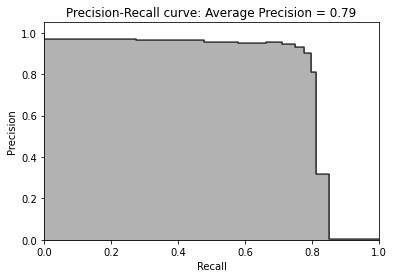

In [114]:
#Precision Recall Curve
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,1]], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsRandomForests = preds.copy()

precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],
                                                       preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],
                                            preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))



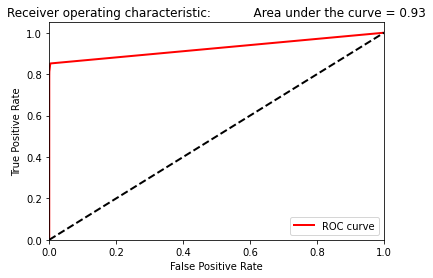

In [113]:
#auROC Curve for Random Forest
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
          Area under the curve = {0:0.2f}'.format(
          areaUnderROC))
plt.legend(loc="lower right")
plt.show()

In [125]:
#GRADIENT BOOSTING
#XG Boost 
#Set hyperparameters
params_xGB = {
    'nthread':16, #number of cores
    'learning rate': 0.25, #range 0 to 1, default 0.3
    'gamma': 0, #range 0 to infinity, default 0 increase to reduce complexity (increase bias, reduce variance)
    'max_depth': 6, #range 1 to infinity, default 6
    'min_child_weight': 1, #range 0 to infinity, default 1
    'max_delta_step': 0, #range 0 to infinity, default 0
    'subsample': 1.0, #range 0 to 1, default 1
        # subsample ratio of the training examples
    'colsample_bytree': 1.0, #range 0 to 1, default 1 
        # subsample ratio of features
    'objective':'binary:logistic',
    'num_class':1,
    'eval_metric':'logloss',
    'seed':2018,
    'silent':1
}

In [124]:

#Train the XGBoost model with Kfolds model
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(x_train)), y_train.ravel()):
    X_train_fold, X_cv_fold = x_train.iloc[train_index,:],x_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    dtrain = xgb.DMatrix(data=X_train_fold, label=y_train_fold)
    dCV = xgb.DMatrix(data=X_cv_fold)
    
    bst = xgb.cv(params_xGB, dtrain, num_boost_round=2000, nfold=5, early_stopping_rounds=200, verbose_eval=50)
    
    best_rounds = np.argmin(bst['test-logloss-mean'])
    bst = xgb.train(params_xGB, dtrain, best_rounds)
    
    loglossTraining = log_loss(y_train_fold, bst.predict(dtrain))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = bst.predict(dCV)
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossXGBoostGradientBoosting = log_loss(y_train, predictionsBasedOnKFolds.loc[:,'prediction'])
print('XGBoost Gradient Boosting Log Loss: ', loglossXGBoostGradientBoosting)

C:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:55:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:55:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:55:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false

C:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:58:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:58:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:58:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false

C:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12:01:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:01:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:01:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false

C:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12:04:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:04:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:04:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false

C:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12:08:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:08:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:08:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false

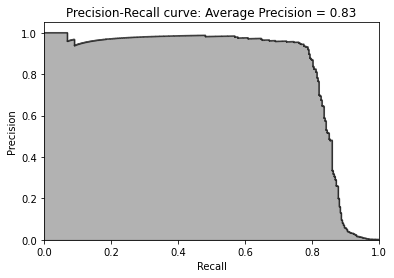

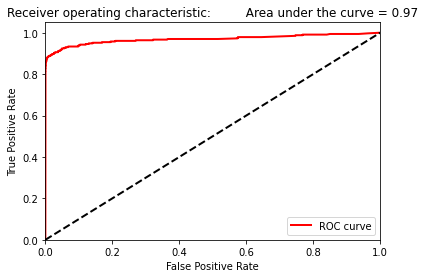

In [126]:
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,'prediction']], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsXGBoostGradientBoosting = preds.copy()

precision, recall, thresholds = \
    precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = \
    average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
        Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

In [137]:
# GRADIENT BOOSTING USING LIGHTGBM
#Set Hyperparameters
params_lightGB = {
    'task': 'train',
    'application':'binary',
    'num_class':1,
    'boosting': 'gbdt',
    #'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': 0,
    'num_threads':8
}

In [140]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],
                                index=y_train.index,columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(x_train)),
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = x_train.iloc[train_index,:], \
        x_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, \
                gbm.predict(X_train_fold, num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
        gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, \
        predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMGradientBoosting = \
    log_loss(y_train, predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', loglossLightGBMGradientBoosting)
print('LightGBM Gradient Boosting Log Loss: ', loglossLightGBMGradientBoosting)

C:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_logloss: 0.00634114
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_logloss: 0.00627112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's binary_logloss: 0.00620101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's binary_logloss: 0.00615075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's binary_logloss: 0.00609434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's binary_logloss: 0.00605295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7

C:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_logloss: 0.00650326
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_logloss: 0.00640306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's binary_logloss: 0.00634257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's binary_logloss: 0.0062795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's binary_logloss: 0.00622988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's binary_logloss: 0.00617384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]

C:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_logloss: 0.00598384
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_logloss: 0.00591432
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's binary_logloss: 0.00583833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's binary_logloss: 0.00576795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's binary_logloss: 0.00569503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's binary_logloss: 0.0056158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]

C:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_logloss: 0.00626824
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.00613614
[3]	valid_0's binary_logloss: 0.00606553
[4]	valid_0's binary_logloss: 0.00600419
[5]	valid_0's binary_logloss: 0.00592515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's binary_logloss: 0.00587399
[7]	valid_0's binary_logloss: 0.00581134
[8]	valid_0's binary_logloss: 0.00576212
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9]	valid_0's binary_logloss: 0.00569973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's binary_logloss: 0.00564938
[11]	valid_0's binary_logloss: 0.00558742
[LightGBM] [Warning]

C:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_logloss: 0.00657581
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_logloss: 0.00650764
[3]	valid_0's binary_logloss: 0.00644821
[4]	valid_0's binary_logloss: 0.00639364
[5]	valid_0's binary_logloss: 0.00633425
[6]	valid_0's binary_logloss: 0.00628249
[7]	valid_0's binary_logloss: 0.00624081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	valid_0's binary_logloss: 0.00619428
[9]	valid_0's binary_logloss: 0.00615368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's binary_logloss: 0.00611468
[11]	valid_0's binary_logloss: 0.00607785
[12]	valid_0's binar

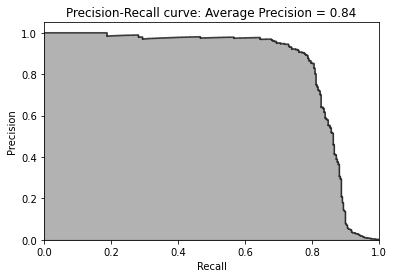

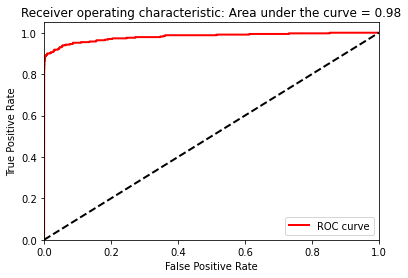

In [141]:
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,'prediction']], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsLightGBMGradientBoosting = preds.copy()

precision, recall, thresholds = \
    precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = \
    average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

In [144]:
# EVALUATION OF THE TEST SET WITH THE 4 ML MODELS 
predictionsTestSetLogisticRegression = pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
predictionsTestSetLogisticRegression.loc[:,'prediction'] = logReg.predict_proba(x_test)[:,1]
logLossTestSetLogisticRegression = log_loss(y_test, predictionsTestSetLogisticRegression)


In [145]:
predictionsTestSetRandomForest = pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
predictionsTestSetRandomForest.loc[:,'prediction'] = RFC.predict_proba(x_test)[:,1]
logLossTestSetRandomForest = log_loss(y_test, predictionsTestSetRandomForest)




In [147]:
predictionsTestSetXGBoostGradientBoosting = pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
dtest = xgb.DMatrix(data=x_test)
predictionsTestSetXGBoostGradientBoosting.loc[:,'prediction'] = bst.predict(dtest)
logLossTestSetXGBoostGradientBoosting = log_loss(y_test, predictionsTestSetXGBoostGradientBoosting)

C:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [148]:
predictionsTestSetLightGBMGradientBoosting = pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
dtest = xgb.DMatrix(data=x_test)
predictionsTestSetLightGBMGradientBoosting.loc[:,'prediction'] = gbm.predict(x_test, num_iteration=gbm.best_iteration)
logLossTestSetLightGBMGradientBoosting = log_loss(y_test, predictionsTestSetLightGBMGradientBoosting)


C:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [149]:
print("Log Loss of Logistic Regression on Test Set: ", logLossTestSetLogisticRegression)
print("Log Loss of Random Forests on Test Set: ", logLossTestSetRandomForest)
print("Log Loss of XGBoost Gradient Boosting on Test Set: ", logLossTestSetXGBoostGradientBoosting)
print("Log Loss of LightGBM Gradient Boosting on Test Set: ", logLossTestSetLightGBMGradientBoosting)

Log Loss of Logistic Regression on Test Set:  0.09670916349010499
Log Loss of Random Forests on Test Set:  0.009018284462863804
Log Loss of XGBoost Gradient Boosting on Test Set:  0.0024243733072886655
Log Loss of LightGBM Gradient Boosting on Test Set:  0.002543994033166086


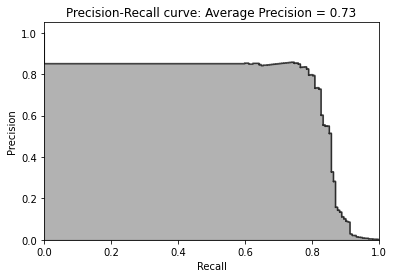

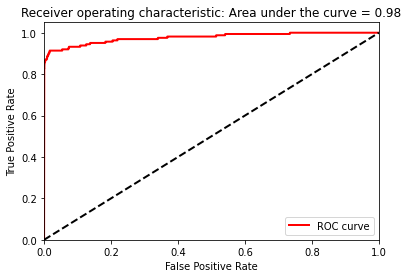

In [150]:
precision, recall, thresholds = precision_recall_curve(y_test,predictionsTestSetLogisticRegression)
average_precision = average_precision_score(y_test,predictionsTestSetLogisticRegression)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

fpr, tpr, thresholds = roc_curve(y_test,predictionsTestSetLogisticRegression)
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

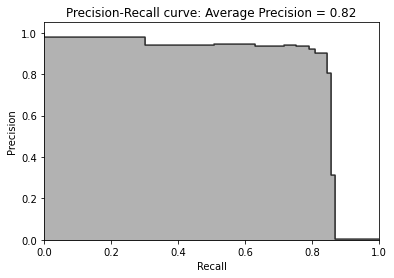

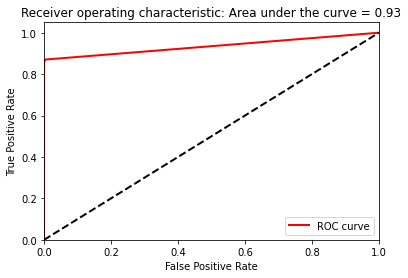

In [151]:
precision, recall, thresholds = precision_recall_curve(y_test,predictionsTestSetRandomForest)
average_precision = average_precision_score(y_test,predictionsTestSetRandomForest)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

fpr, tpr, thresholds = roc_curve(y_test,predictionsTestSetRandomForest)
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

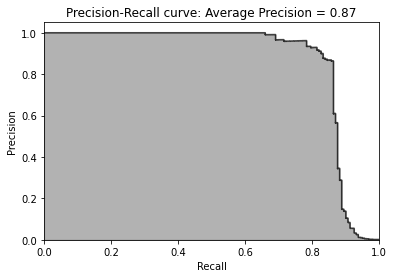

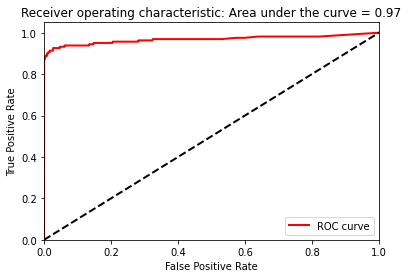

In [152]:
precision, recall, thresholds = precision_recall_curve(y_test,predictionsTestSetXGBoostGradientBoosting)
average_precision = average_precision_score(y_test,predictionsTestSetXGBoostGradientBoosting)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

fpr, tpr, thresholds = \
    roc_curve(y_test,predictionsTestSetXGBoostGradientBoosting)
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

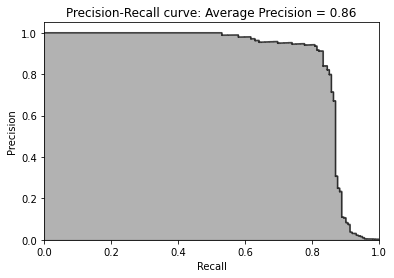

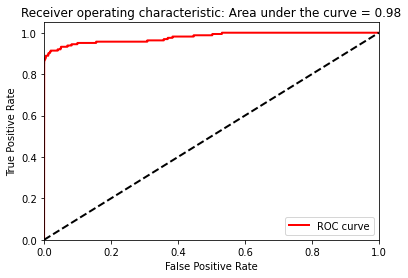

In [153]:
precision, recall, thresholds = precision_recall_curve(y_test,predictionsTestSetLightGBMGradientBoosting)
average_precision = average_precision_score(y_test,predictionsTestSetLightGBMGradientBoosting)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

fpr, tpr, thresholds = \
    roc_curve(y_test,predictionsTestSetLightGBMGradientBoosting)
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

In [155]:
#ENSAMBLE TRAINING - Providing the predictions of the four ML models to train on a new dataset 
#Cobining layer 1 predictions into a DF
predictionsBasedOnKFoldsFourModels = pd.DataFrame(data=[],index=y_train.index)
predictionsBasedOnKFoldsFourModels = \
    predictionsBasedOnKFoldsFourModels.join(predictionsBasedOnKFoldsLogistricRegression['prediction'].astype(float),how='left')\
    .join(predictionsBasedOnKFoldsRandomForests['prediction'].astype(float),how='left',rsuffix="2")\
    .join(predictionsBasedOnKFoldsXGBoostGradientBoosting['prediction'].astype(float),how='left',rsuffix="3")\
    .join(predictionsBasedOnKFoldsLightGBMGradientBoosting['prediction'].astype(float), \
    how='left',rsuffix="4")
predictionsBasedOnKFoldsFourModels.columns = ['predsLR','predsRF','predsXGB','predsLightGBM']
predictionsBasedOnKFoldsFourModels

,predsLR,predsRF,predsXGB,predsLightGBM
142087,0.000829,0.0,0.000113,0.000018
165168,0.031747,0.0,0.000187,0.000081
235908,0.163201,0.0,0.000095,0.000054
148255,0.007044,0.0,0.000065,0.000055
145672,0.036726,0.0,0.000184,0.000175
...,...,...,...,...
30023,0.253480,0.0,0.000113,0.000072
195475,0.039151,0.0,0.000189,0.000121
48687,0.018481,0.0,0.000131,0.000040
159608,0.004789,0.0,0.000153,0.000007


In [160]:
#Merge prediction DF with training data
X_trainWithPredictions = x_train.merge(predictionsBasedOnKFoldsFourModels,left_index=True,right_index=True)
X_trainWithPredictions

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V24,V25,V26,V27,V28,Amount,predsLR,predsRF,predsXGB,predsLightGBM
142087,84575.0,-1.981958,1.933460,0.305345,-0.356982,-0.533313,-0.065841,-0.238248,1.113825,-0.242343,...,-0.355334,-0.084147,0.111366,0.212020,0.156344,13.99,0.000829,0.0,0.000113,0.000018
165168,117245.0,0.141365,1.098390,-0.366686,-0.538319,0.965420,-0.844916,1.037264,-0.164037,-0.183759,...,0.653494,-0.397063,0.106378,0.227831,0.086810,3.87,0.031747,0.0,0.000187,0.000081
235908,148591.0,0.195044,-0.643710,-1.432682,-2.112563,-0.124961,-1.171783,1.558808,-0.689223,-3.030623,...,1.143004,-0.495214,0.093904,0.159268,0.268700,213.40,0.163201,0.0,0.000095,0.000054
148255,89630.0,0.030601,0.859108,0.290804,-0.591915,0.441892,-1.033405,1.016281,-0.190080,-0.066897,...,-0.016869,-0.498699,0.142886,0.250215,0.097351,5.99,0.007044,0.0,0.000065,0.000055
145672,87121.0,0.017960,0.866609,0.263352,-0.473687,1.057894,0.672911,0.331240,0.225852,-0.204932,...,-0.440669,-1.138396,-0.071485,0.236466,0.251605,4.99,0.036726,0.0,0.000184,0.000175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30023,35743.0,-0.488687,0.166906,1.379606,-0.975304,-0.537877,-1.291099,0.500367,-0.353419,-1.452776,...,0.985516,0.327752,-0.145530,-0.044476,0.018997,28.00,0.253480,0.0,0.000113,0.000072
195475,131077.0,-0.497686,-4.552162,-3.158123,1.019695,-1.063958,0.058374,1.666589,-0.369512,0.309615,...,0.370216,-0.451032,0.625165,-0.364470,0.150407,1340.41,0.039151,0.0,0.000189,0.000121
48687,43742.0,0.207689,-1.867709,-0.713193,0.221505,-0.764161,-0.501496,0.809238,-0.338811,0.225005,...,-0.375966,0.057042,0.835926,-0.202497,0.099087,599.00,0.018481,0.0,0.000131,0.000040
159608,112716.0,0.109095,0.820418,-0.149979,-0.825409,0.893693,-0.524624,1.002682,-0.138959,0.034570,...,-1.012910,-0.350652,0.202805,0.243677,0.087102,8.08,0.004789,0.0,0.000153,0.000007


In [161]:
#train on the new training set
#Set the hyperparams
params_lightGB = {
    'task': 'train',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': -1,
    'num_threads':16
}

In [162]:
trainingScores = []
cvScores = []
predictionsBasedOnKFoldsEnsemble = pd.DataFrame(data=[],index=y_train.index,columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(x_train)),y_train.ravel()):
    X_train_fold, X_cv_fold = X_trainWithPredictions.iloc[train_index,:], X_trainWithPredictions.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold, num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFoldsEnsemble.loc[X_cv_fold.index,'prediction'] = gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFoldsEnsemble.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossEnsemble = log_loss(y_train, \
        predictionsBasedOnKFoldsEnsemble.loc[:,'prediction'])
print('Ensemble Log Loss: ', loglossEnsemble)

C:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.00556926
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.00551735
[3]	valid_0's binary_logloss: 0.00546967
[4]	valid_0's binary_logloss: 0.00541107
[5]	valid_0's binary_logloss: 0.00536642
[6]	valid_0's binary_logloss: 0.00530408
[7]	valid_0's binary_logloss: 0.00526241
[8]	valid_0's binary_logloss: 0.0052234
[9]	valid_0's binary_logloss: 0.00518256
[10]	valid_0's binary_logloss: 0.00514267
[11]	valid_0's binary_logloss: 0.00509697
[12]	valid_0's binary_logloss: 0.00505968
[13]	valid_0's binary_logloss: 0.00502169
[14]	valid_0's binary_logloss: 0.00498739
[15]	valid_0's binary_logloss: 0.00494725
[16]	valid_0's binary_logloss: 0.00491351
[17]	valid_0's binary_logloss: 0.0048813
[18]	valid_0's binary_logloss: 0.00484556
[19]	valid_0's binary_logloss: 0.00481341
[20]	valid_0's binary_logloss: 0.00478321
[21]	valid_0's binary_logloss: 0.0047537
[22]	valid_0's binary_logloss: 0.00472077
[23]	valid_0's binary_logl

C:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.0061419
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.00607035
[3]	valid_0's binary_logloss: 0.0059971
[4]	valid_0's binary_logloss: 0.00592521
[5]	valid_0's binary_logloss: 0.00588029
[6]	valid_0's binary_logloss: 0.00583391
[7]	valid_0's binary_logloss: 0.00577582
[8]	valid_0's binary_logloss: 0.00572939
[9]	valid_0's binary_logloss: 0.00568227
[10]	valid_0's binary_logloss: 0.00563365
[11]	valid_0's binary_logloss: 0.00558158
[12]	valid_0's binary_logloss: 0.00553528
[13]	valid_0's binary_logloss: 0.00548794
[14]	valid_0's binary_logloss: 0.00544992
[15]	valid_0's binary_logloss: 0.005408
[16]	valid_0's binary_logloss: 0.00536696
[17]	valid_0's binary_logloss: 0.00532748
[18]	valid_0's binary_logloss: 0.00528929
[19]	valid_0's binary_logloss: 0.00525027
[20]	valid_0's binary_logloss: 0.00521268
[21]	valid_0's binary_logloss: 0.00517624
[22]	valid_0's binary_logloss: 0.00514144
[23]	valid_0's binary_loglo

C:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.00542112
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.00534348
[3]	valid_0's binary_logloss: 0.00526613
[4]	valid_0's binary_logloss: 0.00520748
[5]	valid_0's binary_logloss: 0.0051415
[6]	valid_0's binary_logloss: 0.00508669
[7]	valid_0's binary_logloss: 0.00503509
[8]	valid_0's binary_logloss: 0.00498917
[9]	valid_0's binary_logloss: 0.00494112
[10]	valid_0's binary_logloss: 0.00488813
[11]	valid_0's binary_logloss: 0.00484196
[12]	valid_0's binary_logloss: 0.00480062
[13]	valid_0's binary_logloss: 0.00476082
[14]	valid_0's binary_logloss: 0.00472251
[15]	valid_0's binary_logloss: 0.00468208
[16]	valid_0's binary_logloss: 0.00464676
[17]	valid_0's binary_logloss: 0.00460899
[18]	valid_0's binary_logloss: 0.00457128
[19]	valid_0's binary_logloss: 0.00453868
[20]	valid_0's binary_logloss: 0.00450731
[21]	valid_0's binary_logloss: 0.0044756
[22]	valid_0's binary_logloss: 0.00444515
[23]	valid_0's binary_log

C:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.00578066
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.00570043
[3]	valid_0's binary_logloss: 0.00563602
[4]	valid_0's binary_logloss: 0.0055745
[5]	valid_0's binary_logloss: 0.0055158
[6]	valid_0's binary_logloss: 0.00546317
[7]	valid_0's binary_logloss: 0.00541723
[8]	valid_0's binary_logloss: 0.00536006
[9]	valid_0's binary_logloss: 0.00531418
[10]	valid_0's binary_logloss: 0.00526164
[11]	valid_0's binary_logloss: 0.00520951
[12]	valid_0's binary_logloss: 0.00516056
[13]	valid_0's binary_logloss: 0.00511482
[14]	valid_0's binary_logloss: 0.00507063
[15]	valid_0's binary_logloss: 0.00502774
[16]	valid_0's binary_logloss: 0.00498656
[17]	valid_0's binary_logloss: 0.00494616
[18]	valid_0's binary_logloss: 0.00490582
[19]	valid_0's binary_logloss: 0.00486717
[20]	valid_0's binary_logloss: 0.00483456
[21]	valid_0's binary_logloss: 0.00480227
[22]	valid_0's binary_logloss: 0.00477075
[23]	valid_0's binary_log

C:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.00622104
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.00614756
[3]	valid_0's binary_logloss: 0.00607128
[4]	valid_0's binary_logloss: 0.00600862
[5]	valid_0's binary_logloss: 0.00595157
[6]	valid_0's binary_logloss: 0.00589861
[7]	valid_0's binary_logloss: 0.00584912
[8]	valid_0's binary_logloss: 0.00580173
[9]	valid_0's binary_logloss: 0.00575848
[10]	valid_0's binary_logloss: 0.00569646
[11]	valid_0's binary_logloss: 0.005654
[12]	valid_0's binary_logloss: 0.00560176
[13]	valid_0's binary_logloss: 0.00556123
[14]	valid_0's binary_logloss: 0.00551403
[15]	valid_0's binary_logloss: 0.00547572
[16]	valid_0's binary_logloss: 0.00543937
[17]	valid_0's binary_logloss: 0.00540554
[18]	valid_0's binary_logloss: 0.00536878
[19]	valid_0's binary_logloss: 0.00533247
[20]	valid_0's binary_logloss: 0.00530019
[21]	valid_0's binary_logloss: 0.00526635
[22]	valid_0's binary_logloss: 0.00523054
[23]	valid_0's binary_log

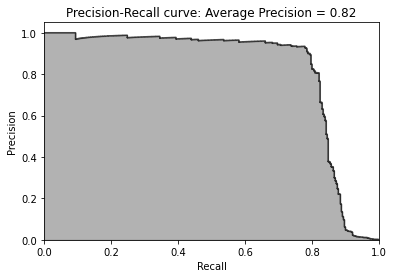

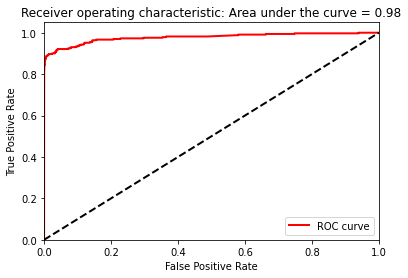

In [163]:

#The Ensamble model did not improve the log loss or auROC - the best method stands with LightGBM
preds = pd.concat([y_train,predictionsBasedOnKFoldsEnsemble.loc[:,'prediction']], axis=1)
preds.columns = ['trueLabel','prediction']

precision, recall, thresholds = \
    precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = \
    average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

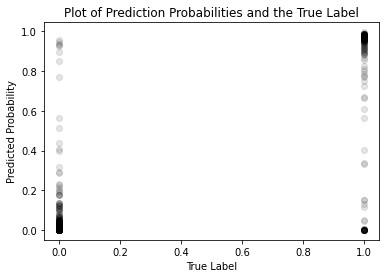

In [165]:
scatterData = predictionsTestSetLightGBMGradientBoosting.join(y_test,how='left')
scatterData.columns = ['Predicted Probability','True Label']
ax = sns.regplot(x="True Label", y="Predicted Probability", color='k', 
                 fit_reg=False, scatter_kws={'alpha':0.1},
                 data=scatterData).set_title( \
                'Plot of Prediction Probabilities and the True Label')



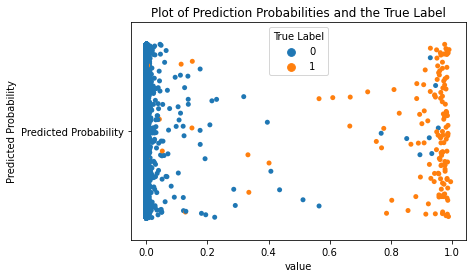

In [166]:
scatterDataMelted = pd.melt(scatterData, "True Label",var_name="Predicted Probability")
ax = sns.stripplot(x="value", y="Predicted Probability", \
                   hue='True Label', jitter=0.4, \
                   data=scatterDataMelted).set_title( \
                   'Plot of Prediction Probabilities and the True Label')

In [ ]:
# Pipeline for New Data
# first, import new data into a dataframe called 'newData'
# second, scale data
# newData.loc[:,featuresToScale] = sX.transform(newData[featuresToScale])
# third, predict using LightGBM
# gbm.predict(newData, num_iteration=gbm.best_iteration)